# Data Ingestion

In [1]:
import torch
import numpy as np
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    #torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
import scipy.io as sio

kuka_data = sio.loadmat('../data/KukaDirectDynamics.mat')

In [3]:
print(kuka_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'kukatraj1', 'kukatraj10', 'kukatraj2', 'kukatraj3', 'kukatraj4', 'kukatraj5', 'kukatraj6', 'kukatraj7', 'kukatraj8', 'kukatraj9'])


In [4]:
import numpy as np

trajectories = {}
total = 0
# Filter out non-trajectory keys and prepare data for training
for key, value in kuka_data.items():
    if key.startswith('kukatraj') and isinstance(value, np.ndarray):
      print(f'{key} - {len(value)}')
      total += len(value)
      trajectories[key] = value

print(f'Total: {total}')

kukatraj1 - 1814
kukatraj10 - 1997
kukatraj2 - 1857
kukatraj3 - 1971
kukatraj4 - 1941
kukatraj5 - 1915
kukatraj6 - 2061
kukatraj7 - 1984
kukatraj8 - 2509
kukatraj9 - 2019
Total: 20068


In [ ]:
# KUKA LWR4+ dynamic parameters for each link
dynamic_params = [
    # Link 1
    {'mass': 4.1948, 'com': [0.0, 0.0, 0.0], 'inertia': [0.0019, 0.0, 0.0, 0.0, 0.0, 0.0]},
    # Link 2
    {'mass': 4.2997, 'com': [0.0003, -0.0041, 0.0824], 'inertia': [0.0474, 0.0500, 0.0016, -0.0000, 0.0001, -0.0009]},
    # Link 3
    {'mass': 3.6585, 'com': [0.0003, 0.1137, -0.0001], 'inertia': [0.0470, 0.0008, 0.0500, -0.0003, 0.0000, -0.0006]},
    # Link 4
    {'mass': 2.3847, 'com': [-0.0015, -0.0000, 0.1486], 'inertia': [0.0124, 0.0073, 0.0100, 0.0000, -0.0005, -0.0005]},
    # Link 5
    {'mass': 1.7036, 'com': [-0.0004, -0.0554, -0.0101], 'inertia': [0.0063, 0.0012, 0.0071, -0.0002, 0.0000, -0.0050]},
    # Link 6
    {'mass': 0.4001, 'com': [0.0021, 0.0586, -0.0448], 'inertia': [0.0005, 0.0000, 0.0035, 0.0000, -0.0000, -0.0011]},
    # Link 7
    {'mass': 0.6501, 'com': [-0.0005, 0.0015, 0.0716], 'inertia': [0.0000, 0.0000, 0.0001, -0.0000, 0.0000, 0.0000]}
]

# Optimisation
---

In [ ]:
import optuna
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import sys
import utils
sys.path.append('models')

import pc_esn_model

# --- Setup: Do this ONCE outside the objective function ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Create a fixed train/validation split to speed up the search
all_keys = sorted(list(trajectories.keys()))
train_keys = all_keys[:8]  # Use 8 trajectories for training
validation_keys = all_keys[8:] # Use 2 for validation

print(f"Training on: {train_keys}")
print(f"Validating on: {validation_keys}")

# 2. Prepare and scale the training data ONCE
train_traj = np.concatenate([trajectories[key] for key in train_keys], axis=0)
X_train, y_train = train_traj[:, :21], train_traj[:, 21:]

x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(y_train)

X_train_t = torch.from_numpy(X_train_scaled).float().to(device)
y_train_t = torch.from_numpy(y_train_scaled).float().to(device)
# --- End of one-time setup ---


def objective(trial):
    """
    Revised objective function for Optuna.
    Optimizes for step-by-step error on a fixed validation set.
    """
    # 1. Define the hyperparameter search space
    params = {
        'n_reservoir': trial.suggest_int('n_reservoir', 500, 1500, step=50), # Slice plot shows that n_reservoir max out the search space for most trials so need to check if it performs better with even larger n_reservoir
        'spectral_radius': trial.suggest_float('spectral_radius', 0.75, 0.95, step=0.05), # Original PC-ESN++ paper recommends radius to be less than 1 for better trajectory performance
        'sparsity': trial.suggest_float('sparsity', 0.6, 0.99, step=0.01), # Slice plot also showed that sparcity was maxed out so will check if even higher value improves performance
        'leak_rate': trial.suggest_float('leak_rate', 0.1, 0.9, step=0.1), # Leak rate was quite confident in pervious run so I'll just increase the step in this run
        'ghl_eta': trial.suggest_float('ghl_eta', 1e-5, 1e-3, log=True), # will reduce the range
        'ghl_decay_steps': trial.suggest_int('ghl_decay_steps', 10000, 30000, step=1000) # did not optimise previous run so will run this time
    }

    joint_positions = np.zeros(7)  # Assuming 7 joints

    # KUKA LWR4+ DH parameters
    dh_params = np.array([
        [  0,         0,      0.3105,  joint_positions[0]               ],
        [ -np.pi/2,   0,      0.0,     joint_positions[1] - np.pi/2     ],
        [  np.pi/2,   0,      0.4005,  joint_positions[2]               ],
        [  np.pi/2,   0,      0.0,     joint_positions[3] + np.pi/2     ],
        [ -np.pi/2,   0,      0.3900,  joint_positions[4]               ],
        [ -np.pi/2,   0,      0.0,     joint_positions[5] - np.pi/2     ],
        [  np.pi/2,   0,      0.0780,  joint_positions[6]               ]
    ])
    
    # 2. Model Training (uses the pre-prepared training data)
    model = pc_esn_model.PC_ESN(n_inputs=21, n_outputs=14, 
                   device=device, **params,
                  dh_params=dh_params,
                   dynamic_params=dynamic_params,)
    model.train(X_train_t, y_train_t)

    # 3. Evaluation on the validation set
    validation_errors = []
    for val_key in validation_keys:
        val_traj = trajectories[val_key]
        X_val, y_val = val_traj[:, :21], val_traj[:, 21:]

        # Use the scaler that was fitted on the training data
        X_val_scaled = x_scaler.transform(X_val)
        X_val_t = torch.from_numpy(X_val_scaled).float().to(device)

        # *** Use step-by-step prediction for a stable optimization metric ***
        y_pred_scaled, _ = model.predict_full_trajectory(X_val_t)
        y_pred = y_scaler.inverse_transform(y_pred_scaled)

        # Calculate the nMSE for position (first 7 outputs)
        pos_error = utils.nMSE(y_val[:, :7], y_pred[:, :7])
        validation_errors.append(pos_error)

    # Return the average error across the validation trajectories
    final_average_error = np.mean(validation_errors)

    return final_average_error

Training on: ['kukatraj1', 'kukatraj10', 'kukatraj2', 'kukatraj3', 'kukatraj4', 'kukatraj5', 'kukatraj6', 'kukatraj7']
Validating on: ['kukatraj8', 'kukatraj9']


In [9]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2025-08-06 10:17:47,105] A new study created in memory with name: no-name-7f68f480-528c-4a51-9f98-4a7f80b943d8
/tmp/ipykernel_13/3015213950.py:203: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  var_i = (self.beta[i] / self.alpha[i]) * (1 + c_t.T @ self.V[i] @ c_t)
[I 2025-08-06 10:20:30,049] Trial 0 finished with value: 0.7857628123428919 and parameters: {'n_reservoir': 700, 'spectral_radius': 0.9, 'sparsity': 0.9199999999999999, 'leak_rate': 0.6, 'ghl_eta': 0.00020472910885519185, 'ghl_decay_steps': 23000}. Best is trial 0 with value: 0.7857628123428919.
[I 2025-08-06 10:23:16,314] Trial 1 finished with value: 1.2031624225420567 and parameters: {'n_reservoir': 700

In [10]:
# After the study is complete, you can get the best results.
print("Optimization finished!")
print("Best trial:")
best_trial = study.best_trial
print(f"  Value (nMSE): {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

Optimization finished!
Best trial:
  Value (nMSE): 0.6942638250163073
  Params: 
    n_reservoir: 750
    spectral_radius: 0.9
    sparsity: 0.85
    leak_rate: 0.7000000000000001
    ghl_eta: 0.00012827395978719472
    ghl_decay_steps: 24000


/tmp/ipykernel_13/1799482134.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  opplt.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

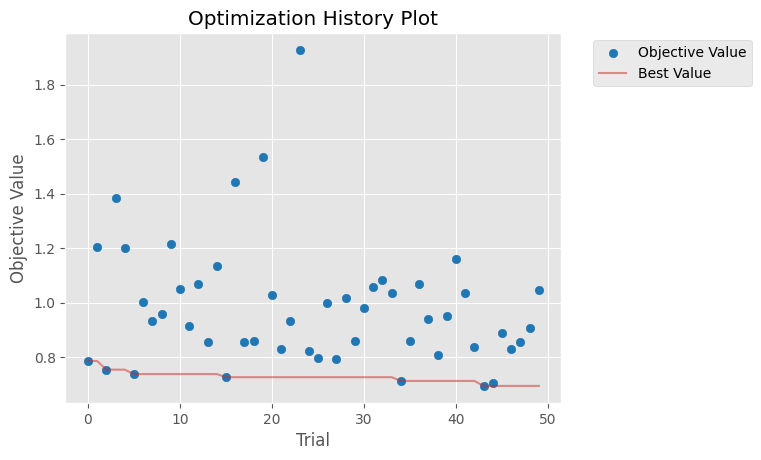

In [11]:
import optuna.visualization.matplotlib as opplt
opplt.plot_optimization_history(study)

/tmp/ipykernel_13/2166294799.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  opplt.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

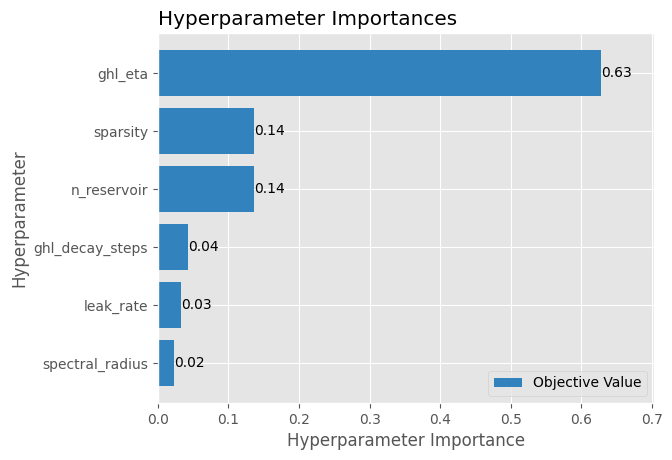

In [12]:
opplt.plot_param_importances(study)

/tmp/ipykernel_13/4088376440.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  opplt.plot_slice(study, params=['n_reservoir', 'spectral_radius', 'sparsity', 'leak_rate', 'ghl_eta', 'ghl_decay_steps'])


array([<Axes: xlabel='ghl_decay_steps', ylabel='Objective Value'>,
       <Axes: xlabel='ghl_eta'>, <Axes: xlabel='leak_rate'>,
       <Axes: xlabel='n_reservoir'>, <Axes: xlabel='sparsity'>,
       <Axes: xlabel='spectral_radius'>], dtype=object)

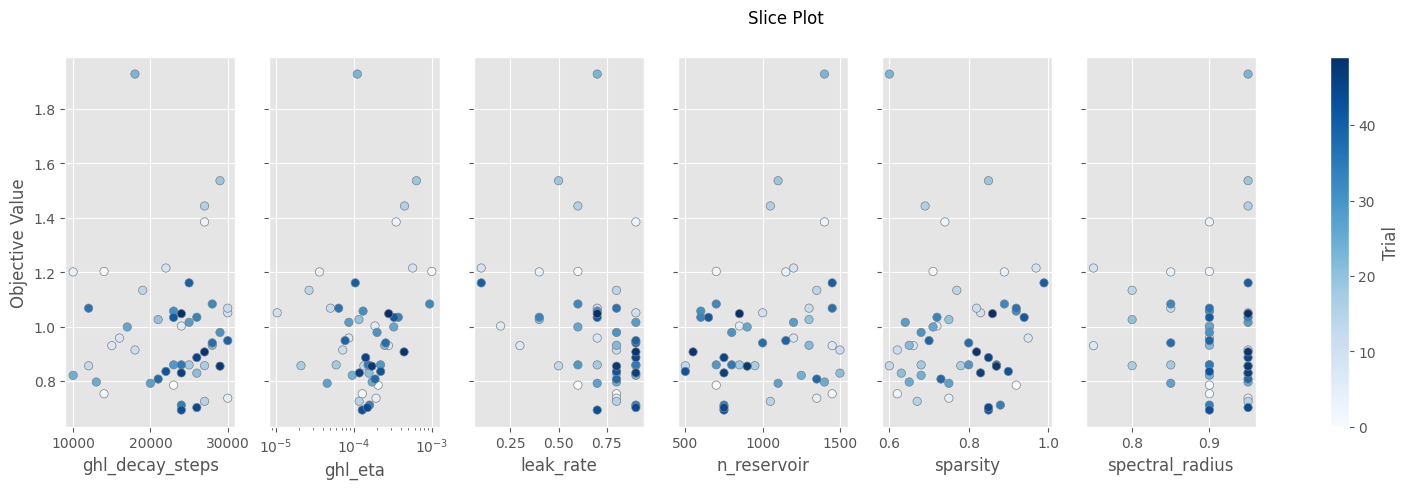

In [13]:
opplt.plot_slice(study, params=['n_reservoir', 'spectral_radius', 'sparsity', 'leak_rate', 'ghl_eta', 'ghl_decay_steps'])
